Gabriel Marcelino

## Load Data and Install Dependencies

In [3]:
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Check current working directory and list files
print("Current working directory:", os.getcwd())
print("Files in the directory:", os.listdir())

# Load metadata
metadata_path = '../../cv-corpus-20.0-delta-2024-12-06/en/validated.tsv'
print(f"Loading metadata from: {metadata_path}")
try:
    metadata = pd.read_csv(metadata_path, sep='\t')
    print("Metadata loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

Current working directory: /Users/gabriel/Desktop/SPRING2025/CST 440/Code/Speech-Text
Files in the directory: ['Labs', 'SpeechRecognition.ipynb', 'README.md', 'model.keras', '.gitignore', '.git', 'asr_model.h5']
Loading metadata from: ../../cv-corpus-20.0-delta-2024-12-06/en/validated.tsv
Metadata loaded successfully.


## Pre Process Data

In [4]:

# Preprocess audio
def preprocess_audio(file_path, target_sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=None)
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        print(f"Processed audio file: {file_path}, Duration: {len(y_resampled) / target_sr:.2f}s")
        return y_resampled, target_sr
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

# Process all files
audio_data = []
for index, row in metadata.iterrows():
    file_path = os.path.join('../../cv-corpus-20.0-delta-2024-12-06/en/clips', row['path'])
    transcription = row['sentence']
    print(f"Processing file {index + 1}/{len(metadata)}: {file_path}")
    y, sr = preprocess_audio(file_path)
    if y is not None:
        audio_data.append({'audio': y, 'sampling_rate': sr, 'transcription': transcription})
    else:
        print(f"Skipping file: {file_path}")

# Summary
print(f"Processed {len(audio_data)} audio files successfully.")


Processing file 1/250: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41383256.mp3
Processed audio file: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41383256.mp3, Duration: 4.82s
Processing file 2/250: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41823983.mp3
Processed audio file: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41823983.mp3, Duration: 4.72s
Processing file 3/250: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41881685.mp3
Processed audio file: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41881685.mp3, Duration: 8.06s
Processing file 4/250: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41799514.mp3
Processed audio file: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41799514.mp3, Duration: 7.92s
Processing file 5/250: ../../cv-corpus-20.0-delta-2024-12-06/en/clips/common_voice_en_41552032.mp3
Processed audio file: ../../cv-corpus-20.0-de

## Experimenting with Data

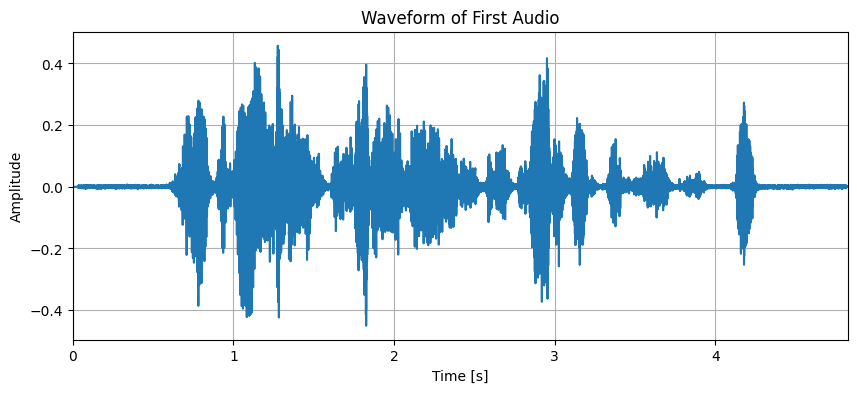

The outer rim has undergone some erosion due to subsequent impacts.


In [5]:
# plot waveform for first audio file
def plot_waveform(y, sr, title='Waveform'):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(y) / sr, num=len(y)), y)
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(y) / sr)
    plt.grid()
    plt.show()

plot_waveform(audio_data[0]['audio'], audio_data[0]['sampling_rate'], title='Waveform of First Audio')
print(audio_data[0]['transcription'])
# playable audio
ipd.Audio(audio_data[0]['audio'], rate=audio_data[0]['sampling_rate'])

## Feature Extraction & Tokenizing Trancriptions

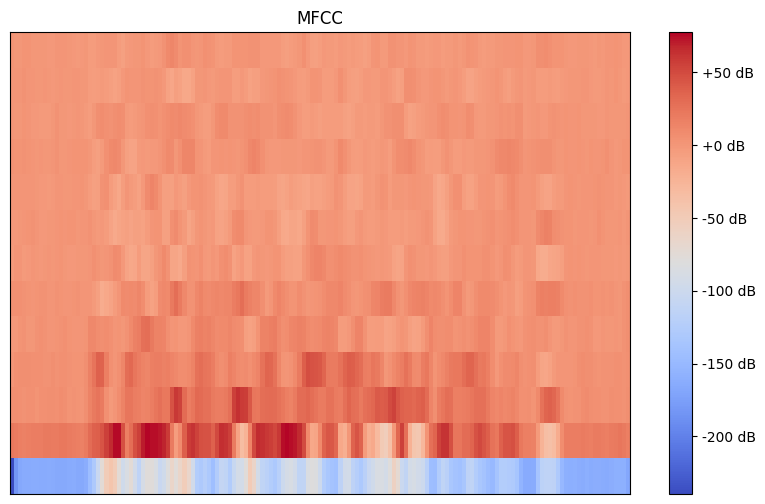

In [10]:
def extract_mfcc(audio, sr, n_mfcc=13, n_mels=23, fmin=0, fmax=8000, hop_length=512, win_length=2048):
    # Compute the Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, hop_length=hop_length, win_length=win_length)
    # Convert Mel spectrogram to MFCC
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), n_mfcc=n_mfcc)
    
    return mfcc

# Example usage
all_mfcc = []
for audio in audio_data:
    mel_spec = extract_mfcc(audio['audio'], sr=16000)
    all_mfcc.append(mel_spec)

# Plot the Mel spectrogram using librosa's specshow
plt.figure(figsize=(10, 6))
librosa.display.specshow(all_mfcc[0])
plt.colorbar(format='%+2.0f dB')
plt.title("MFCC")
plt.show()

# Tokenize the transcriptions (characters or words)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts([audio['transcription'] for audio in audio_data])

# Add a new field 'tokenized_transcript' to each audio_data entry
for audio in audio_data:
    audio['tokenized_transcript'] = tokenizer.texts_to_sequences([audio['transcription']])[0]



## Train Model

In [11]:
# Maximum sequence length
max_len = max([mfcc.shape[1] for mfcc in all_mfcc])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    all_mfcc,
    [audio['tokenized_transcript'] for audio in audio_data],
    test_size=0.2,
    random_state=42
)

# Pad MFCC sequences
padded_X_train = [np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant') for mfcc in X_train]
padded_X_test = [np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant') for mfcc in X_test]

# Transpose to match model input shape (batch, time_steps, features)
X_train = np.transpose(np.array(padded_X_train), (0, 2, 1))
X_test = np.transpose(np.array(padded_X_test), (0, 2, 1))

# Pad target sequences
y_train = pad_sequences(y_train, maxlen=max_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len, padding='post')

# Update model architecture
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(max_len, 13)),
    Dropout(0.2),
    TimeDistributed(Dense(len(tokenizer.word_index) + 1, activation='softmax'))
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Save the model
model.save('model.keras')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 88s 14s/step - accuracy: 0.4565 - loss: 3.5676 - val_accuracy: 0.7585 - val_loss: 2.9865
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.7950 - loss: 2.8310 - val_accuracy: 0.8266 - val_loss: 1.5681
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.8453 - loss: 1.1820 - val_accuracy: 0.8266 - val_loss: 0.8564
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - accuracy: 0.8397 - loss: 0.7986 - val_accuracy: 0.8266 - val_loss: 0.8334
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8354 - loss: 0.7867 - val_accuracy: 0.8266 - val_loss: 0.7824
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.8411 - loss: 0.7243 - val_accuracy: 0.8266 - val_loss: 0.7481
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8427 - loss: 0.6859 - val_accuracy: 0.8266 - val_loss: 0.7331
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.8430 - loss: 0.6730 - val_accuracy: 0.8266 - val_loss: 0.7187
Epoch 9

In [12]:
## DEBUGGING
from sklearn.metrics import classification_report

# After training, evaluate on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten predictions and true labels
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_classes.flatten()

print(classification_report(
    y_true_flat[y_true_flat != 0],  # Exclude padding
    y_pred_flat[y_true_flat != 0]
))

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.16      0.62      0.26       459
           2       0.06      0.02      0.03       309
           3       0.00      0.00      0.00       215
           4       0.00      0.00      0.00       227
           5       0.00      0.00      0.00       202
           6       0.00      0.00      0.00       179
           7       0.14      0.01      0.01       180
           8       0.00      0.00      0.00       176
           9       0.00      0.00      0.00       160
          10       0.00      0.00      0.00       128
          11       0.00      0.00      0.00       111
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00        63
          14       0.00      0.00      0.00        69
          15       0.00      0.00      0.00        66
          16       0.00      0.00      0.00 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

## Evaluation

In [13]:
prediction = model.predict(X_test[:1])
print(prediction.shape)
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)

print("X_test shape:", X_test.shape)
print("X_test[:1]:", X_test[:1])

print("Prediction shape:", prediction.shape)

# Get predicted sequence and filter out padding (0) tokens
predicted_sequence = np.argmax(prediction, axis=-1)[0]  # Get the most likely token for each timestep

# Filter out padding tokens (0) and optionally low-probability tokens
predicted_sequence = [token for idx, token in enumerate(predicted_sequence) if token != 0]

# Decode the filtered sequence
decoded_text = tokenizer.sequences_to_texts([predicted_sequence])[0] if predicted_sequence else "No valid tokens."
print("Decoded Prediction:", decoded_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
(1, 375, 37)
Model input shape: (None, 375, 13)
Model output shape: (None, 375, 37)
X_test shape: (50, 375, 13)
X_test[:1]: [[[-2.5105229e+02  3.8867496e+01  5.4247427e+00 ...  4.1707401e+00
   -3.7050295e+00  2.8336573e-01]
  [-2.0614487e+02  5.2747055e+01 -1.4358039e+00 ...  1.6314934e+00
   -4.2914362e+00 -1.9529104e-02]
  [-2.0852608e+02  5.0606026e+01  9.0310210e-01 ... -1.2369862e+00
   -2.4960401e+00 -1.2397778e+00]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]]
Prediction shape: (1, 375, 37)
Decoded Prediction:                                 t t             t t                


## Results
### Hyperparameters (Initial Setup)  
- LSTM Units: 128 (Bidirectional).
- Dropout: 0.2.
- Dense Units: Size of the tokenizer vocabulary + 1.
- Optimizer: Adam.
- Loss: Sparse categorical crossentropy.
- Batch Size: 32.
- Epochs: 10.
### Analysis: With these parameters, I am getting high accuracy somehow, but the predicted output is empty and doesn't match the transcription. This could be due to an issue with the output layer or how the predicted token sequences are being decoded. It’s possible that the model is producing tokens with very low probability for each timestep, leading to incorrect or empty predictions. Additionally, misalignment between the input MFCC features and tokenized output could be contributing to poor decoding. 
### Tuning: To address this, we'll try adjusting the LSTM units, dropout rate, and batch size for better learning, and ensure that the token decoding process is correct. 
### Hyperparameters (Second Try)  





## Test with Pre-Trained Model

In [22]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
from jiwer import wer, cer
import random

# Load pre-trained model
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Subset size (adjust based on your needs)
subset_size = 100  

# Randomly sample a subset of the data
subset_data = random.sample(audio_data, subset_size)

# Initialize metrics
total_wer = 0
total_cer = 0
num_samples = len(subset_data)

# Evaluate on the subset
for sample in subset_data:
    audio_input = sample['audio']
    transcription_gt = sample['transcription']
    
    # Process the audio
    input_values = processor(audio_input, return_tensors="pt", sampling_rate=16000).input_values

    # Perform inference
    with torch.no_grad():
        logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]
    
    # Calculate metrics for the sample
    sample_wer = wer(transcription_gt.lower(), transcription.lower())
    sample_cer = cer(transcription_gt.lower(), transcription.lower())
    
    # Aggregate metrics
    total_wer += sample_wer
    total_cer += sample_cer

    # Log each result (optional)
    print(f"Ground Truth: {transcription_gt}")
    print(f"Prediction: {transcription}")
    print(f"WER: {sample_wer:.2f}, CER: {sample_cer:.2f}")

# Calculate averages
avg_wer = total_wer / num_samples
avg_cer = total_cer / num_samples

print(f"Average Word Error Rate (WER) for subset: {avg_wer:.2f}")
print(f"Average Character Error Rate (CER) for subset: {avg_cer:.2f}")



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ground Truth: The work is divided into two books.
Prediction: THE WORK IS DIVIDED INTO TWO BULTS
WER: 0.14, CER: 0.11
Ground Truth: Undeletion is not fail-safe.
Prediction: AN DELITION AS NOT FAIL SAFE
WER: 1.25, CER: 0.21
Ground Truth: Coffey opened the Dock Distillery on Grand Canal Street in Dublin.
Prediction: COFFEE OPENED THE DOCDOSTILLERY ON GRAND CANAL STREET IN DUBLIN
WER: 0.36, CER: 0.08
Ground Truth: The bel is seldom used, as the decibel was the proposed working unit.
Prediction: THE BELL IS SELDOM USED AS THE DECIPALE WAS THE PROPOSED BURKING UNIT
WER: 0.38, CER: 0.12
Ground Truth: The composer never married, and no names of lovers are recorded.
Prediction: THE COMPOSER NEVER MARRIED AND NO NAMES OF LOVERS ARE RECARDED
WER: 0.18, CER: 0.05
Ground Truth: George explores the city and rescues a paraglider on the Bay Bridge.
Prediction: GORGE EXPLORES THE CITY AND RESCUES A PARAGLIDER ON THE BAY BRIDGE
WER: 0.17, CER: 0.03
Ground Truth: It's got suspense but no staying power.


## References
https://devopedia.org/audio-feature-extraction

https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/